<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: AMES Housing Dataset

--- 
# Notebook 2

The second notebook will comprise of preprocessing and feature engineering.

---

# 1.0 Data and libraries Import

In [1]:
# Import libraries
import numpy as np
import math
import statistics
import pandas as pd
import seaborn as sns

In [2]:
# Load data in dataframe
X = pd.read_csv('datasets/train_v2_EDA.csv')

## 2.1 One Hot Encode Categorical Variables

In this section, we will attempt to change variables into ordinal data and dumbified variables but firstly we need to fill all missing values in variables that we want to change to ordinal data and numeric values with 0

In [3]:
# Fill Misc Feature to be dumified later
X['Misc Feature'].fillna('None', inplace = True)

# Fill Garage Year Blt with the year the house is build as 0 is meaningless
X['Garage Yr Blt'] = X['Garage Yr Blt'].fillna(X['Year Built'])

# Filling 0 to the rest of the missing variables
X.fillna(0, inplace = True)

### 2.1.1 Ordinal Data

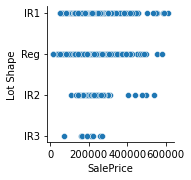

In [4]:
sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Lot Shape']);

# Irregular shapes would not utilise space and should fetch lower price
X['Lot Shape'] = X['Lot Shape'].map({'Reg':3,'IR1':2,'IR2':1,'IR3':0})

In [5]:
X['Land Slope'].value_counts()

# Gentle slopes are definately better for children, elderly and handicap
X['Land Slope'] = X['Land Slope'].map({'Gtl':2,'Mod':1,'Sev':0})

In [6]:
# The data dictionary shows FuseA as average, FuseF as Fair and FuseP as Poor
X['Electrical'] = X['Electrical'].map({'SBrkr':4,'FuseA':3,'FuseF':1, 'FuseP':0, 'Mix':2})

In [7]:
# The data dictionary shows Typ been the best and Sal been the poorest
X['Functional'] = X['Functional'].map({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0})

In [8]:
# Paved will have the highest rank and no the lowest
X['Paved Drive'] = X['Paved Drive'].map({'Y':2, 'P':1, 'N':0})

In [9]:
# Finished to be rank highest and None lowest
X['Garage Finish'] = X['Garage Finish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0, 0:0})

In [10]:
# GLQ to be rank highest and None rank lowest
X['BsmtFin Type 1'] = X['BsmtFin Type 1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0, 0:0})
X['BsmtFin Type 2'] = X['BsmtFin Type 2'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0, 0:0})

In [11]:
# Gd to be rank highest and No as 0
X['Bsmt Exposure'] = X['Bsmt Exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0, 0:0})

In [12]:
# Good Pavement to be rank highest and None rank lowest
X['Fence'] = X['Fence'].map({'GdPrv':4,'GdWo':3,'MnPrv':2,'MnWw':1,'None':0, 0:0})

In [13]:
# Pave to be rank highest and None rank lowest
X['Alley'] = X['Alley'].map({'Pave':2,'Grvl':1, 0:0})

In [14]:
# Mapping 10 variables with the following rating scale
# Create rank for ordinal data
# Giving -2 to Po as poor is worse than none as tear down is needed before renovation.
rank_list = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':0, 'Po':-2, 0:0}

# Create list of variables to map to rank above.
ordinal_vars = ['Exter Qual', 'Exter Cond' , 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']

# Doing a general map across all variables who are rank in this 5 levels. 
# The only variable that does not follow this is Bsmt Exposure which will be dropped and will be discussed below.
for var in ordinal_vars:
    X[var] = X[var].map(rank_list)

In [15]:
# Create rank for ordinal data
rank_list = {'Y':1, 'N':0}

# Change Central Air to Ordinal Data
X['Central Air'] = X['Central Air'].map(rank_list)

### 2.1.2 Dumbified Variables

In [16]:
dumb_vars = ['MS Zoning', 'Street', 'Land Contour', 'Condition 1', 'Condition 2', 
             'House Style', 'Lot Config', 'Neighborhood', 'Roof Style', 'Roof Matl', 
             'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Heating', 'Garage Type', 
             'Mas Vnr Type', 'Misc Feature', 'Sale Type']

for var in dumb_vars:
    X = pd.get_dummies(data=X, columns = [var], dummy_na = True, prefix = var)

### 2.1.3 Variables to be Drop

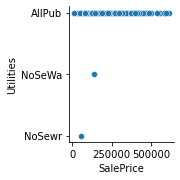

In [17]:
sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Utilities']);

# There are only 2 other values beside ALLPub thus no meaning to train model on 2 values so this variable will be dropped.
X.drop(columns = ['Utilities'], inplace = True)

In [18]:
# Collect all variables with only 0 in a list
zero_cols = [ col for col, is_zero in ((X == 0).sum() == X.shape[0]).items() if is_zero ]

# Drop them as they will not have predictive values
X.drop(zero_cols, axis=1, inplace=True)

In [19]:
# Drop id as it is added only for purpose of submission for compeition.
# Drp pid as the parcel id cannot be ultilise without domain knowledge.

X.drop(columns = ['Id', 'PID'], inplace = True)

In [20]:
# Checking if there are nan values
X.isnull().sum().sum()

0

## 2.2 Manufacture Features with Linear Relationships to the Target

In this section, we will investigate variables and create new ones so that the variables will have linear relationships with target.

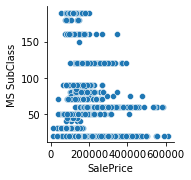

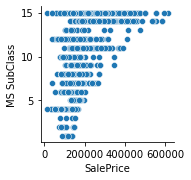

In [21]:
# Pairplot before engineering the MS SubClass
sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['MS SubClass']);

# Reorganise the subclasses to form a linear relationship with SalePrice
# 150 and 180 given the same rank as there is only 1 data of 150 and the 2 subclasses are pretty close
X['MS SubClass'] = X['MS SubClass'].map({20:15, 30:4, 40:3, 45:1, 50:12, 60:14, 70:7, 75:13, 80:9, 85:5, 90:8, 120:11, 150:2, 160:10, 180:2, 190:6})

# Pairplot after engineering the MS SubClass
sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['MS SubClass']);

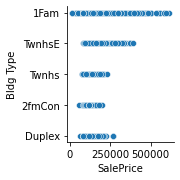

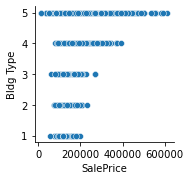

In [22]:
# Pairplot before engineering the Bldg Type
sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Bldg Type']);

X['Bldg Type'] = X['Bldg Type'].map({'1Fam':5, 'TwnhsE':4, 'Duplex':3, 'Twnhs':2, '2fmCon':1})

# Pairplot before engineering the Bldg Type
sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Bldg Type']);

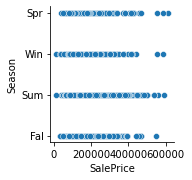

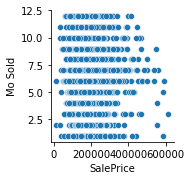

In [23]:
# Changing Months sold into season to reduce number of variables
seasons = {
    'Spr':[3,4,5],
    'Sum':[6,7,8],
    'Fal':[9,10,11],
    'Win':[12,1,2]
}

X['Season'] = X['Mo Sold'].map(lambda x: [i for i in seasons if x in seasons[i]][0])

sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Season']);

sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Mo Sold']);

The new season variable better normalise the data else most of the outliers are found in the first half of the year

In [24]:
# Dumbified Seasons
X = pd.get_dummies(X, columns=['Season'], drop_first = True)

# Drop Month Sold
X.drop(columns = ['Mo Sold'], inplace = True)

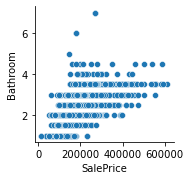

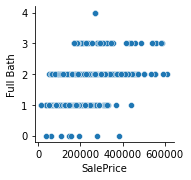

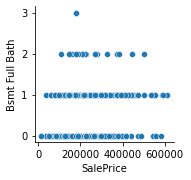

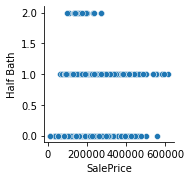

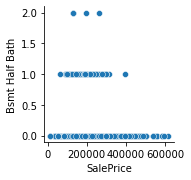

In [25]:
# Combining Full Bath and Half Bath for both basement and house into 1 variable
X['Bathroom'] = X['Full Bath'] + X['Bsmt Full Bath'] + 0.5 * X['Half Bath'] + 0.5 * X['Bsmt Half Bath']

sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Bathroom']);

sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Full Bath']);

sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Bsmt Full Bath']);

sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Half Bath']);

sns.pairplot(data=X,
             x_vars=['SalePrice'],
             y_vars=['Bsmt Half Bath']);

The new bathroom variable is more linearly correlated with SalePrice thus the variable will be retained.

In [26]:
# Drop Bath Variables
X.drop(columns = ['Full Bath', 'Bsmt Full Bath', 'Half Bath', 'Bsmt Half Bath'], inplace = True)

In [27]:
# Drop None Variables created during Dummified
X.drop(columns = ['Mas Vnr Type_None', 'Misc Feature_None'], inplace = True)

C:\Users\Bezalel\anaconda3\lib\site-packages\seaborn\axisgrid.py:1183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(len(y_vars), len(x_vars),


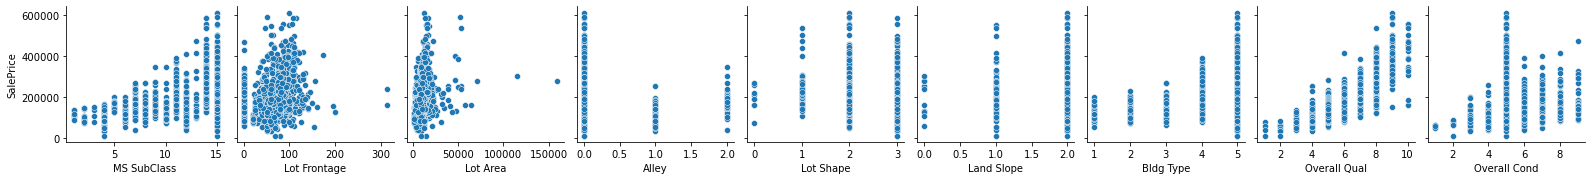

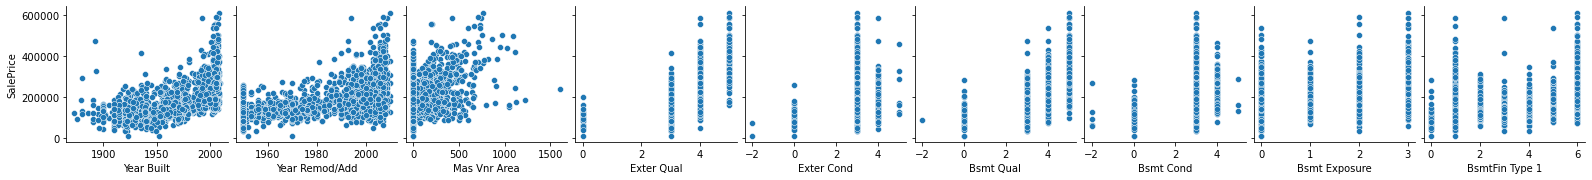

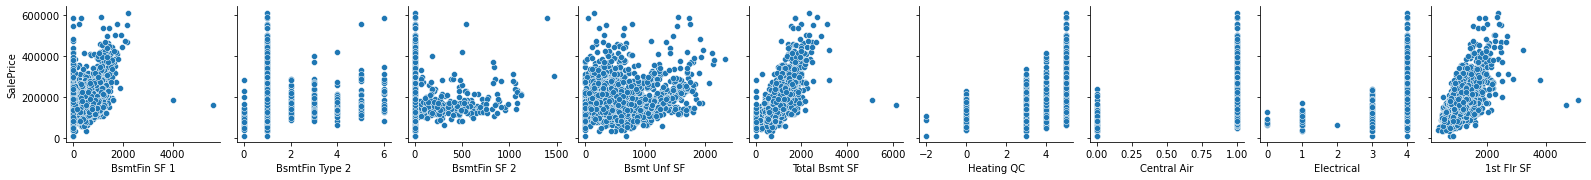

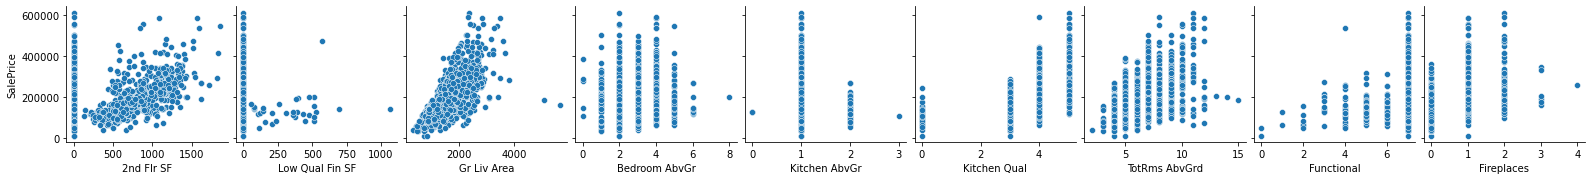

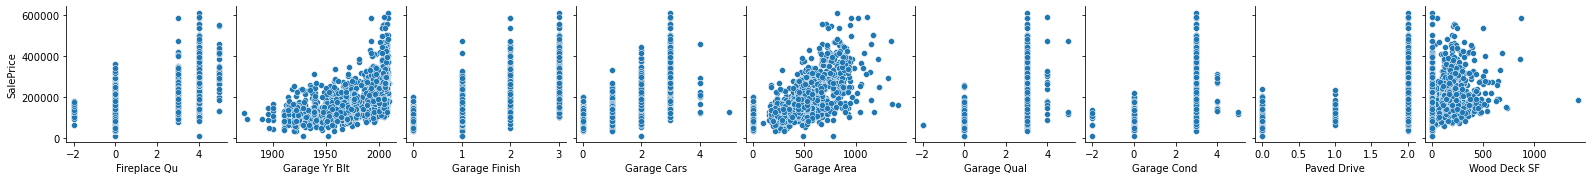

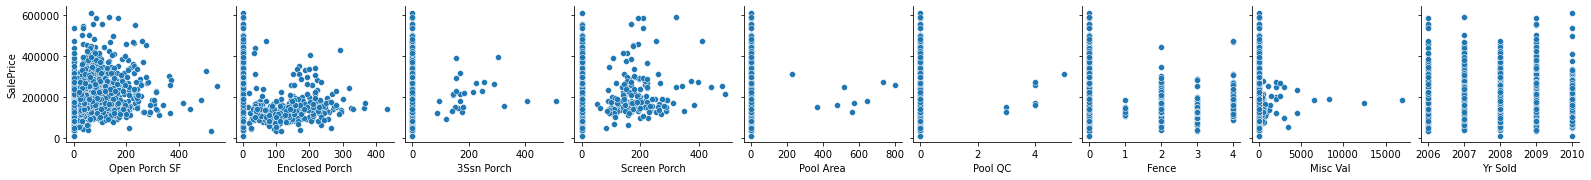

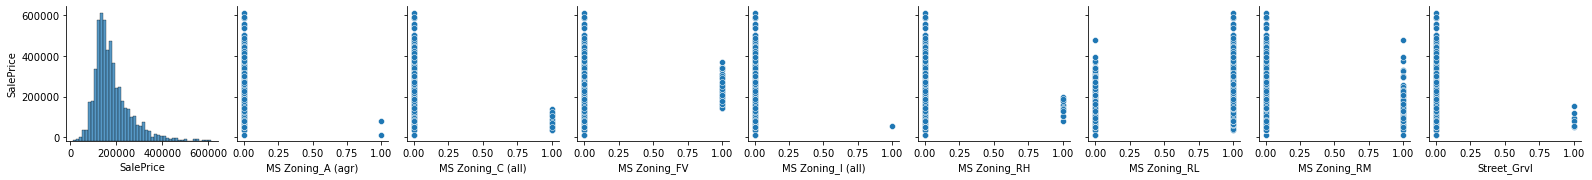

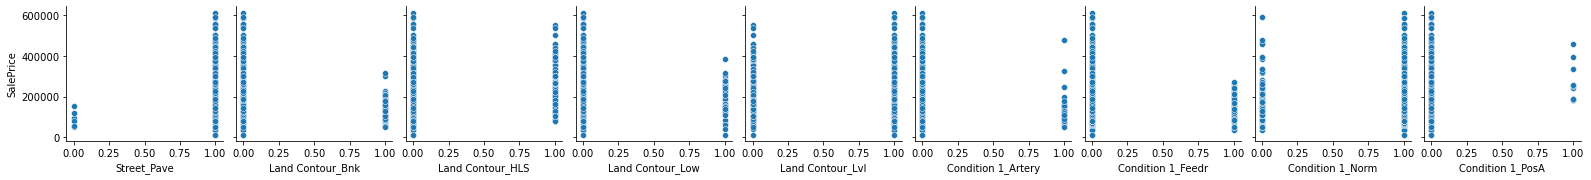

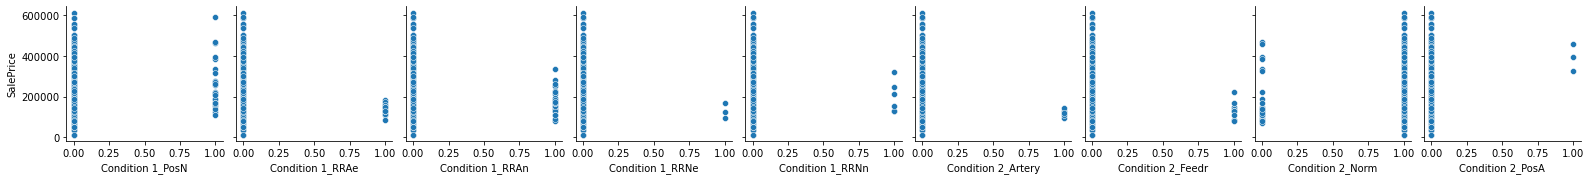

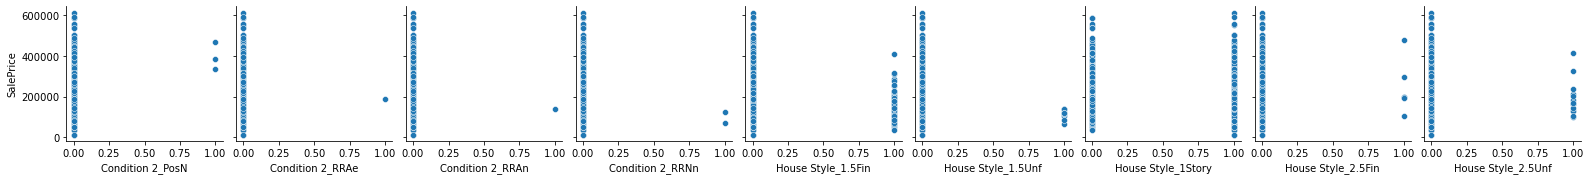

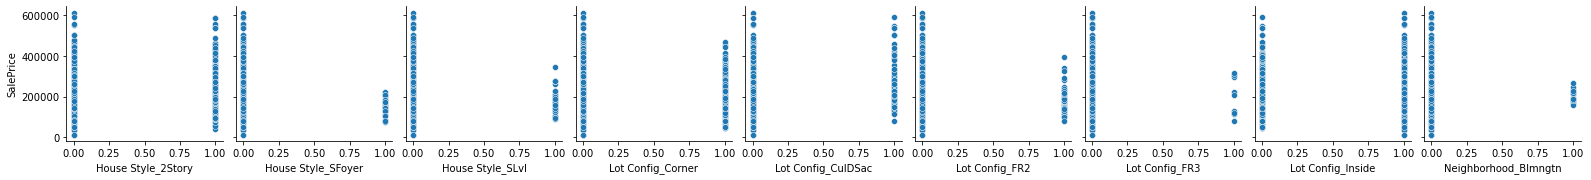

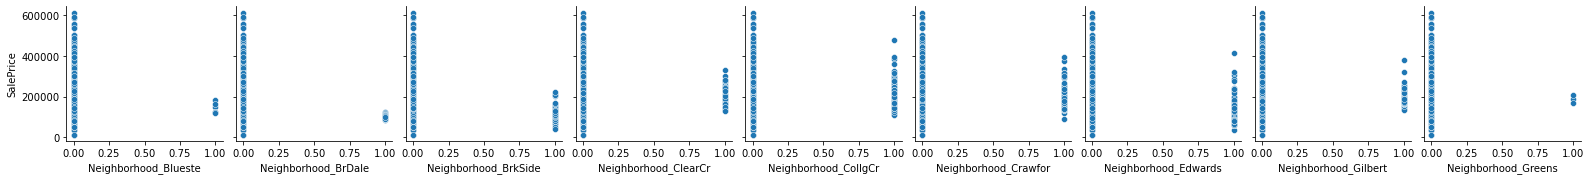

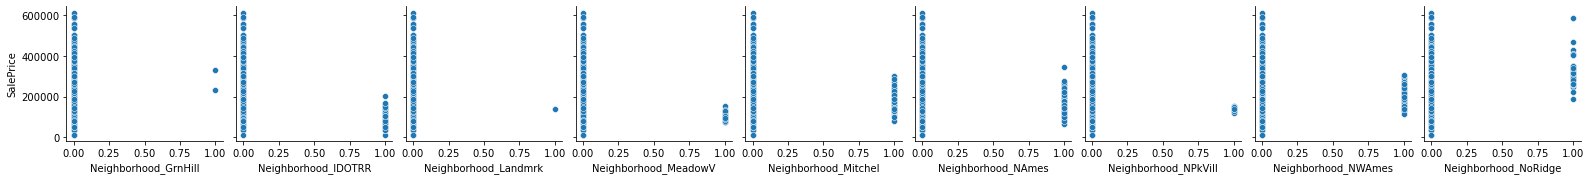

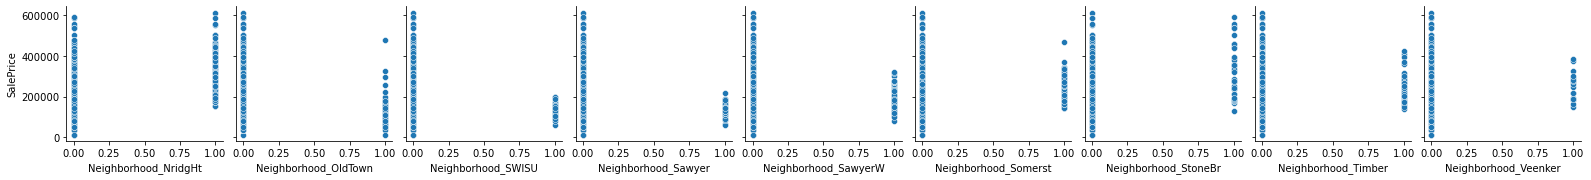

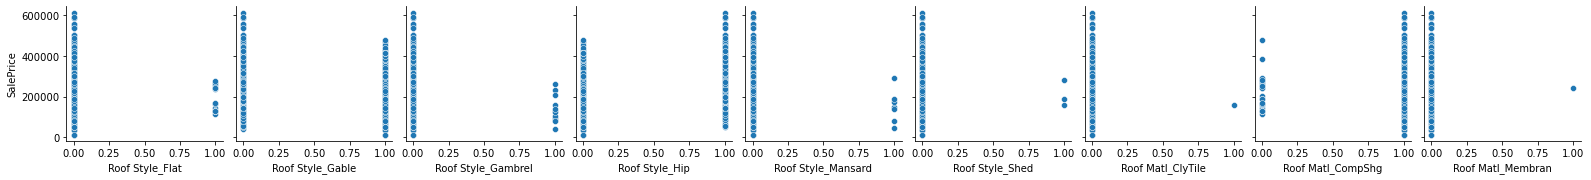

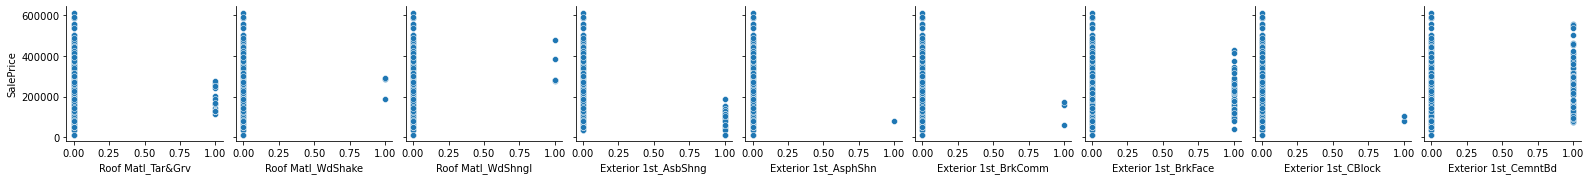

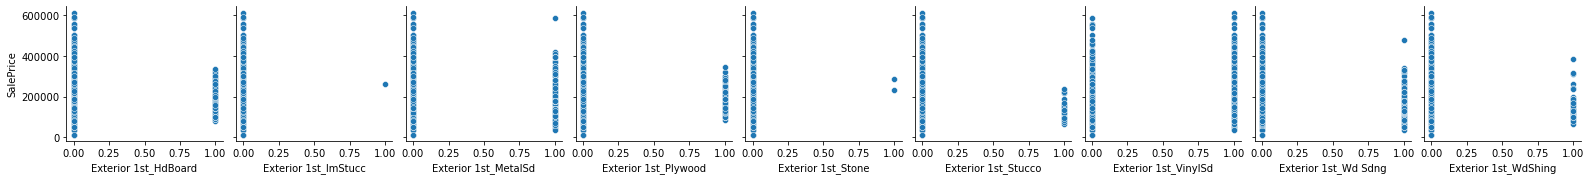

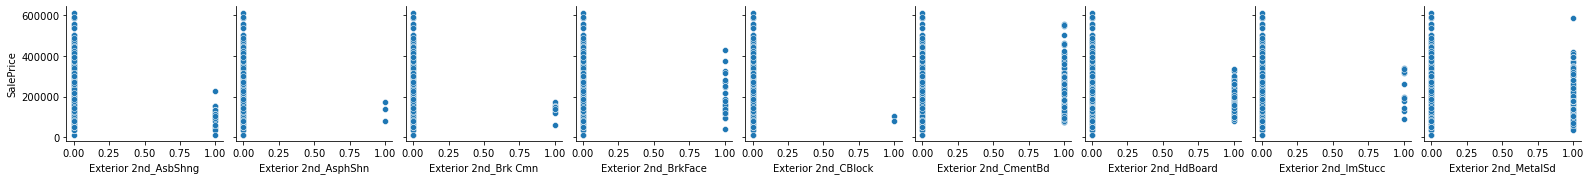

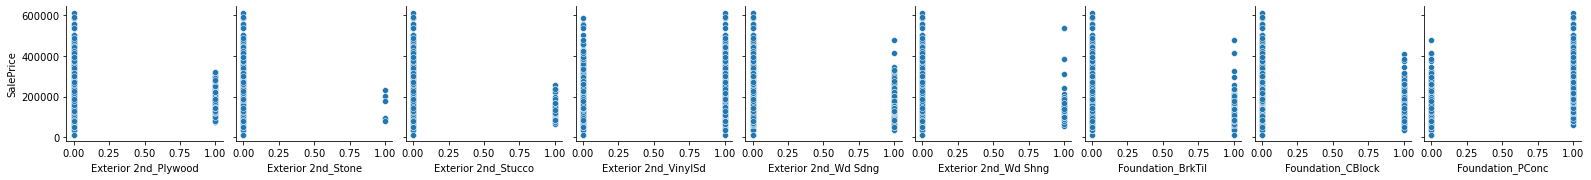

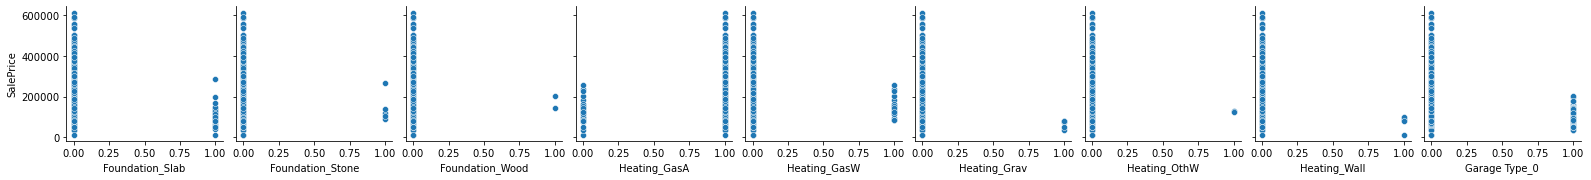

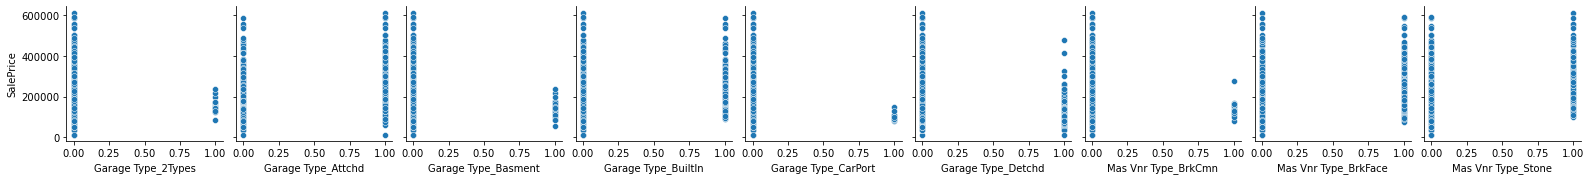

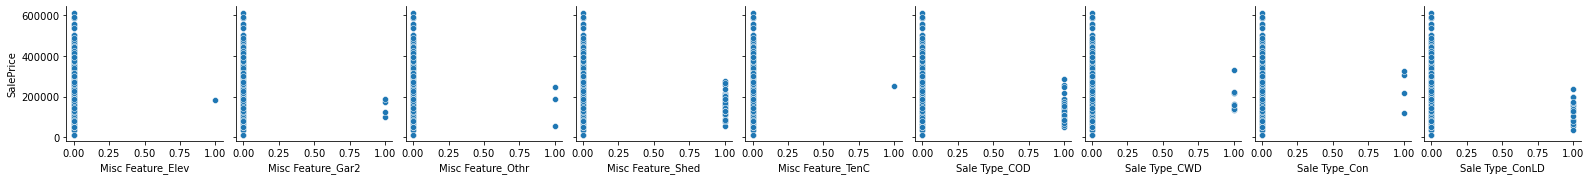

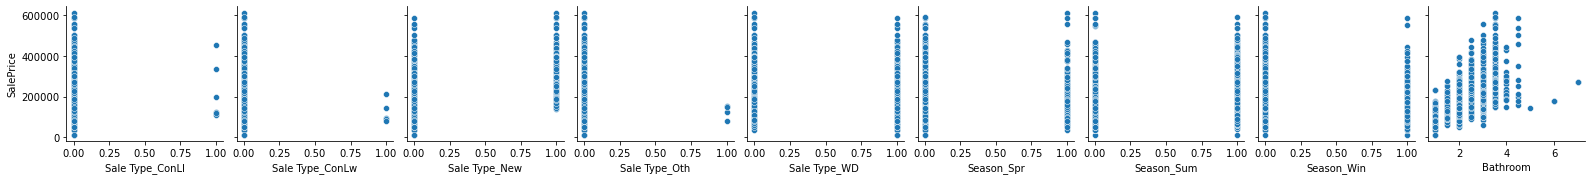

In [28]:
cl = X.columns

for count in range(0,len(cl),9):
    sns.pairplot(data=X,
                x_vars =[cl[count],cl[count+1],cl[count+2],cl[count+3],cl[count+4],cl[count+5],cl[count+6],cl[count+7],cl[count+8]],
                y_vars =['SalePrice'])

In [30]:
# Drop variables with skew data from the pairplot above.
X.drop(columns = ['MS Zoning_A (agr)', 'MS Zoning_I (all)', 'Foundation_Wood', 
                  'Condition 2_RRAe', 'Condition 2_RRAn', 'Condition 1_RRNn',
                  'Neighborhood_GrnHill', 'Neighborhood_Landmrk', 'Roof Style_Shed',
                  'Roof Matl_ClyTile', 'Roof Matl_Membran', 'Roof Matl_WdShngl',
                  'Roof Matl_WdShake', 'Roof Style_Shed', 'Exterior 1st_AsbShng',
                  'Exterior 1st_BrkComm', 'Exterior 1st_CBlock', 'Exterior 1st_ImStucc',
                  'Exterior 1st_Stone', 'Exterior 2nd_AsphShn', 'Exterior 2nd_CBlock',
                  'Heating_OthW', 'Misc Feature_TenC', 'Misc Feature_Elev', 
                  'Misc Feature_Othr','Exterior 2nd_Stone', 'Condition 2_Artery',
                  'Condition 2_PosN', 'Condition 2_RRNn', 'Heating_Wall'], inplace = True)

In [31]:
# Export data for use in next dataset
X.to_csv("datasets/train_v3_preprocessed.csv", index = False)